# Multi-class text classification with Python 

Using nltk, gensim, scikit-learn.

This notebook follows the tutorial available at: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

In [1]:
# basic
import pandas as pd
import numpy as np

# text processing
import nltk
from nltk.corpus import stopwords 
import re
from bs4 import BeautifulSoup
import gensim
from gensim.models import Word2Vec

# machine learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression

# misc
import logging

# plots
import matplotlib.pyplot as plt
%matplotlib inline

## Pre-processing

The data comes from https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv

In [2]:
df = pd.read_csv('data/stack-overflow-data.csv') # read data
df = df[pd.notnull(df['tags'])] # filter data removing rows with empty tag
print(df.head(10))
print(df['post'].apply(lambda x: len(x.split(' '))).sum()) # number of words (with duplicates)

                                                post           tags
0  what is causing this behavior  in our c# datet...             c#
1  have dynamic html load as if it was in an ifra...        asp.net
2  how to convert a float value in to min:sec  i ...    objective-c
3  .net framework 4 redistributable  just wonderi...           .net
4  trying to calculate and print the mean and its...         python
5  how to give alias name for my website  i have ...        asp.net
6  window.open() returns null in angularjs  it wo...      angularjs
7  identifying server timeout quickly in iphone  ...         iphone
8  unknown method key  error in rails 2.3.8 unit ...  ruby-on-rails
9  from the include  how to show and hide the con...      angularjs
10286120


Each post is associated with a tag (programming language/framework, our classification labels). There are >10m words (with duplicates) in the data.

We can explore the distributions of tags, to make sure labels will be balanced:

In [3]:
my_tags = df['tags'].unique() # extract unique tags
print(my_tags)

['c#' 'asp.net' 'objective-c' '.net' 'python' 'angularjs' 'iphone'
 'ruby-on-rails' 'ios' 'c' 'sql' 'java' 'jquery' 'css' 'c++' 'php'
 'android' 'mysql' 'javascript' 'html']


Plot distribution:

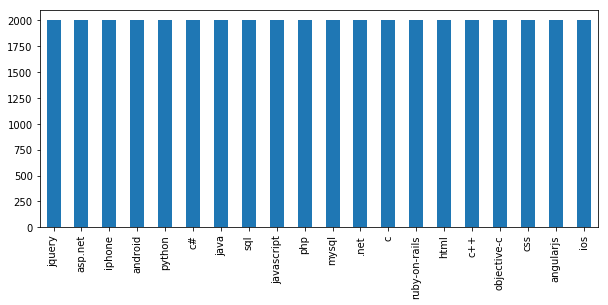

In [4]:
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

Perfectly balanced.

Next, we define a function to quickly take a look at any post with its tag, using its index. Useful to explore data, see what needs to be clean, and to compare data before/after text processing.

In [5]:
def print_post(index):
    example = df[df.index == index].values[0] # get post
    if len(example) > 0: # if not empty, print post and tag
        print(example[0])
        print('Tag:', example[1])

For example:

In [6]:
print_post(10)

when we need interface c# <blockquote>    <strong>possible duplicate:</strong><br>   <a href= https://stackoverflow.com/questions/240152/why-would-i-want-to-use-interfaces >why would i want to use interfaces </a>   <a href= https://stackoverflow.com/questions/9451868/why-i-need-interface >why i need interface </a>    </blockquote>     i want to know where and when to use it     for example    <pre><code>interface idemo {  // function prototype  public void show(); }  // first class using the interface class myclass1 : idemo {  public void show()  {   // function body comes here   response.write( i m in myclass );  }  }  // second class using the interface class myclass2 : idemo {  public void show()   {   // function body comes here   response.write( i m in myclass2 );   response.write( so  what  );  } </code></pre>   these two classes has the same function name with different body. this can be even achieved without interface. then why we need an interface where and when to use it
Tag:

We can observe the text needs to be clean, in particular remove html tags and other symbols.

To do so, we define a function which strips problematic symbols, remove stopwords, and set everything to lowercase.

In [7]:
symbols_to_replace = re.compile('[/(){}\[\]\|@,;]') # these we replace with spaces
symbols_to_remove = re.compile('[^0-9a-z #+_]') # these we remove
stopwords_to_remove = set(stopwords.words('english')) # english stopwords to remove

def clean_post(text):
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = symbols_to_replace.sub(' ', text) # replace symbols with space in text
    text = symbols_to_remove.sub('', text) # delete symbols from text
    text = ' '.join(word for word in text.split() if word not in stopwords_to_remove) # delete stopwors from text
    return text

For example:

In [8]:
dirty_text = "when we need interface c# <blockquote> <strong>possible duplicate:</strong><br> {  // function prototype  public void show();"
clean_text = clean_post(dirty_text)
print(clean_text)

need interface c# possible duplicate function prototype public void show


Apply function to all posts:

In [9]:
df['post'] = df['post'].apply(clean_post)
print_post(10)

need interface c# possible duplicate would want use interfaces need interface want know use example interface idemo function prototype public void show first class using interface class myclass1 idemo public void show function body comes responsewrite myclass second class using interface class myclass2 idemo public void show function body comes responsewrite myclass2 responsewrite two classes function name different body even achieved without interface need interface use
Tag: c#


How many words now?

In [10]:
df['post'].apply(lambda x: len(x.split(' '))).sum()

3424297

After cleaning, there are "only" ~3.5m words (with duplicates).

Next, we can move to splitting train and test set, and feature engineering.

In [11]:
X = df.post # features are the posts
y = df.tags # labels are the tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42) # split

## First model: multinomial Naive Bayes

Using tf-idf representation of features. We use scikit-learn's pipeline.

In [12]:
# define pipeline
nb = Pipeline([('vect', CountVectorizer()), # transform text into matrix of token counts
               ('tfidf', TfidfTransformer()), # from token counts to normalized tf-idf
               ('clf', MultinomialNB()), # naive bayes classifier
              ])

nb.fit(X_train, y_train) # training

y_pred = nb.predict(X_test) # inference on test set

# print report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7395
               precision    recall  f1-score   support

           c#       0.63      0.65      0.64       613
      asp.net       0.94      0.86      0.90       620
  objective-c       0.87      0.92      0.90       587
         .net       0.70      0.77      0.73       586
       python       0.73      0.87      0.79       599
    angularjs       0.72      0.51      0.60       589
       iphone       0.77      0.74      0.75       594
ruby-on-rails       0.69      0.89      0.78       610
          ios       0.63      0.59      0.61       617
            c       0.57      0.65      0.60       587
          sql       0.70      0.50      0.59       611
         java       0.79      0.78      0.79       594
       jquery       0.84      0.59      0.69       619
          css       0.66      0.84      0.74       574
          c++       0.64      0.83      0.72       584
          php       0.66      0.64      0.65       578
      android       0.79      0.77      0.78    

Not a bad start for an out-of-the-box model.

## Second model: linear support vector machine

(again on tf-idf transformed features)

In [13]:
sgd = Pipeline([('vect', CountVectorizer()), # same as before
                ('tfidf', TfidfTransformer()), # same as before
                ('clf', SGDClassifier(loss='hinge', # linear SVM: parameters?
                                      penalty='l2',
                                      alpha=1e-3,
                                      random_state=42,
                                      max_iter=5,
                                      tol=None)),
               ])

sgd.fit(X_train, y_train) # training

y_pred = sgd.predict(X_test) # test

# print report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7883333333333333
               precision    recall  f1-score   support

           c#       0.74      0.67      0.70       613
      asp.net       0.84      0.93      0.88       620
  objective-c       0.87      0.95      0.91       587
         .net       0.81      0.80      0.81       586
       python       0.74      0.88      0.81       599
    angularjs       0.76      0.40      0.52       589
       iphone       0.83      0.68      0.75       594
ruby-on-rails       0.70      0.95      0.81       610
          ios       0.82      0.56      0.66       617
            c       0.72      0.59      0.65       587
          sql       0.71      0.65      0.68       611
         java       0.81      0.87      0.84       594
       jquery       0.76      0.79      0.78       619
          css       0.83      0.86      0.85       574
          c++       0.82      0.80      0.81       584
          php       0.70      0.68      0.69       578
      android       0.80      0.90  

SVM results in a small, but not negligible, improvement. What's the trade-off? Can it get even better tweaking the parameters?

## Third model: logistic regression

In [14]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, # parameters?
                                           C=1e5)),
               ])

logreg.fit(X_train, y_train) # training

y_pred = logreg.predict(X_test) # test

# print report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.7823333333333333
               precision    recall  f1-score   support

           c#       0.70      0.62      0.66       613
      asp.net       0.91      0.91      0.91       620
  objective-c       0.97      0.94      0.95       587
         .net       0.78      0.77      0.78       586
       python       0.77      0.81      0.79       599
    angularjs       0.60      0.58      0.59       589
       iphone       0.78      0.75      0.76       594
ruby-on-rails       0.82      0.85      0.83       610
          ios       0.69      0.71      0.70       617
            c       0.61      0.59      0.60       587
          sql       0.63      0.63      0.63       611
         java       0.83      0.83      0.83       594
       jquery       0.78      0.78      0.78       619
          css       0.84      0.85      0.85       574
          c++       0.80      0.83      0.82       584
          php       0.65      0.64      0.65       578
      android       0.82      0.85  

Worse than SVM, better than Naive Bayes. 

Next, we look at other feature representations.

## Fourth model: logistic regression

With word2vec embeddings feature representation.

Pre-trained word2vec model can be downloaded from https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download and imported via gensim nlp library. 

In [15]:
wv = gensim.models.KeyedVectors.load_word2vec_format("embeddings/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

One way of leveraging word vectors is with bag-of-words: each sentence is tokenized and converted into a set of word vectors, a function of which (sum, weighted average, ...) is used as feature. This abstracts away from word order. 

Here we use average:

In [16]:
def w2v_tokenize_text(text): # tokenizer
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

def word_averaging(wv, words): # word vector lookup and averaging sentence-wise
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # TO DO: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list): # this is the function which will be applied to posts
    return np.vstack([word_averaging(wv, post) for post in text_list])

Next, we split again train and test and we apply our functions to posts:

In [17]:
train, test = train_test_split(df, test_size=0.3, random_state = 42)

train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

train_word_average = word_averaging_list(wv,train_tokenized)
test_word_average = word_averaging_list(wv,test_tokenized)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).


We fit logistic regression with the processed features:

In [18]:
logreg = LogisticRegression(n_jobs=1, C=1e5) # initialize classifier

logreg = logreg.fit(train_word_average, train['tags']) # train

y_pred = logreg.predict(test_word_average) # inference

# print report
print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred,target_names=my_tags))

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.6380833333333333
               precision    recall  f1-score   support

           c#       0.63      0.59      0.61       613
      asp.net       0.74      0.76      0.75       620
  objective-c       0.65      0.67      0.66       587
         .net       0.53      0.52      0.52       586
       python       0.70      0.77      0.73       599
    angularjs       0.44      0.39      0.41       589
       iphone       0.65      0.60      0.63       594
ruby-on-rails       0.73      0.80      0.76       610
          ios       0.61      0.61      0.61       617
            c       0.56      0.52      0.54       587
          sql       0.55      0.50      0.52       611
         java       0.61      0.61      0.61       594
       jquery       0.65      0.65      0.65       619
          css       0.61      0.57      0.59       574
          c++       0.70      0.71      0.70       584
          php       0.43      0.43      0.43       578
      android       0.68      0.71  

The worst result so far.

## Deep learning (with Keras)

In [19]:
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

Using TensorFlow backend.


In [20]:
# pre-processing and settings

train_size = int(len(df) * .7) # split train and test data
train_posts = df['post'][:train_size]
train_tags = df['tags'][:train_size]

test_posts = df['post'][train_size:]
test_tags = df['tags'][train_size:]

max_words = 1000 # tokenize
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts)

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder() # encode labels
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

# neural network settings
batch_size = 32
epochs = 2

In [21]:
# define model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
# train
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Instructions for updating:
Use tf.cast instead.


Train on 25200 samples, validate on 2800 samples
Epoch 1/2
25200/25200 [==============================] - 12s 474us/step - loss: 1.0308 - acc: 0.7192 - val_loss: 0.6655 - val_acc: 0.7968
Epoch 2/2
25200/25200 [==============================] - 11s 454us/step - loss: 0.5745 - acc: 0.8150 - val_loss: 0.6574 - val_acc: 0.7936


In [23]:
# accuracy on test set
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

12000/12000 [==============================] - 1s 115us/step
Test accuracy: 0.7963333333333333
